# MLP implementations: 
1. Own MLP class
2. numpy (hardcoded backpropagation)
3. PyTorch tensors (hardcoded backpropagation)
4. PyTorch with CUDA tensors (hardcoded backpropagation)
5. PyTorch framework (automatic differentiation)
6. PyTorch framework with CUDA tensors (automatic differentiation)



Comparison on different implementations of a MLP, modified from: https://github.com/jcjohnson/pytorch-examples
A MLP 3 layers [784, 100, 10] is used as example, no bias elements added to the input layers

In [18]:
%matplotlib notebook
import numpy as np
import pickle, gzip
import mlp
import matplotlib.pyplot as plt
import torch
import time

## Parameters of MLP
 * __Number of layers__ : 3 (input, hidden1, output)
 * __Elements in layers__ : [784, 100, 10]   
 * __Activation function__ : Rectified Linear function
 * __Regularization parameter__ : 0
 * __Bias element added in input layers__ : False
  

In [19]:
# Useful functions
def initalize_weights_relu(size_layer, size_next_layer):
    np.random.seed(5)
    # Method presented in "Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classfication"
    # He et Al. 2015
    epsilon = np.sqrt(2.0 / (size_layer * size_next_layer) )
    # Weigts from Normal distribution mean = 0, std = epsion
    w = epsilon * (np.random.randn(size_next_layer, size_layer))
    return w.transpose()
def load_mnist():
    # Import MNIST data
    with gzip.open('../data/mnist/mnist.pkl.gz', 'rb') as f:
        train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    # Training data, only
    X = valid_set[0]
    y = valid_set[1]

    # change y [1D] to Y [2D] sparse array coding class
    n_examples = len(y)
    labels = np.unique(y)
    Y = np.zeros((n_examples, len(labels)))
    for ix_label in range(len(labels)):
        # Find examples with with a Label = lables(ix_label)
        ix_tmp = np.where(y == labels[ix_label])[0]
        Y[ix_tmp, ix_label] = 1

    return X, Y, labels, y

In [20]:
# Training with 400 epochs
epochs = 400
loss = np.zeros([epochs,1])


## 1. Own implementation, class MLP

59.77893900871277 s


<IPython.core.display.Javascript object>


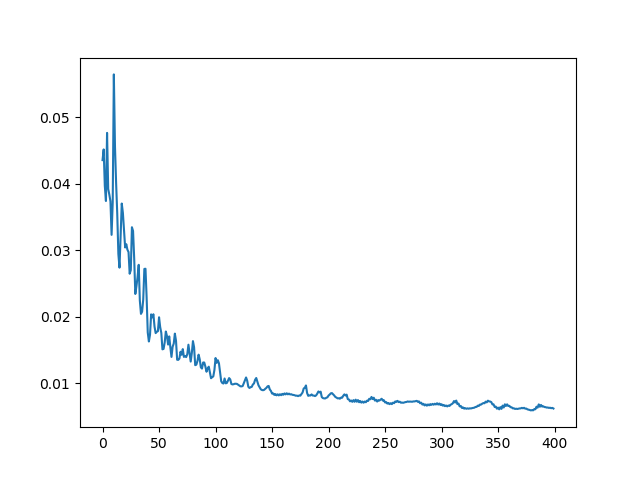

Training Accuracy: 95.73


In [21]:
# Load data
X, Y, labels, y  = load_mnist()

tic = time.time()

# Creating the MLP object initialize the weights
mlp_classifier = mlp.Mlp(size_layers = [784, 100, 10], 
                         act_funct   = 'relu',
                         reg_lambda  = 0,
                         bias_flag   = False)

for ix in range(epochs):
    mlp_classifier.train(X, Y, 1)
    Y_hat = mlp_classifier.predict(X)
    # loss
    loss[ix] = (0.5)*np.square(Y_hat - Y).mean()

print(str(time.time() - tic) + ' s')
        
# Ploting loss vs epochs
plt.figure()
ix = np.arange(epochs)
plt.plot(ix, loss)

# Training Accuracy
Y_hat = mlp_classifier.predict(X)
y_tmp = np.argmax(Y_hat, axis=1)
y_hat = labels[y_tmp]

acc = np.mean(1 * (y_hat == y))
print('Training Accuracy: ' + str(acc*100))

## 2. NumPy implementation
In this case Backpropagation is hard coded for 3 layers

38.03892803192139 s


<IPython.core.display.Javascript object>


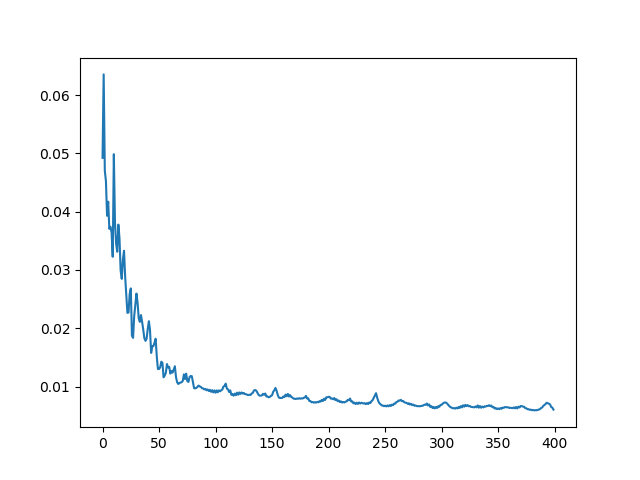

Training Accuracy: 95.74000000000001


In [22]:
# Load data
X, Y, labels, y = load_mnist()
tic = time.time()

# size_layers = [784, 100, 10]

# Randomly initialize weights
w1 = initalize_weights_relu(784, 100)
w2 = initalize_weights_relu(100, 10)

for ix in range(epochs):
    n_examples = X.shape[0]
    # Forward pass: compute y_hat    
    a1 = X
    z2 = a1.dot(w1)
    a2 = np.maximum(z2, 0)
    z3 = a2.dot(w2)
    a3 = np.maximum(z3, 0)
    Y_hat = a3
    
    # Compute loss
    loss[ix] = (0.5) * np.square(Y_hat - Y).mean()
    # Backprop to compute gradients of w1 and w2 with respect to loss
    d3 = Y_hat - Y
    grad2 = a2.T.dot(d3) / n_examples
    d2_tmp = d3.dot(w2.T)
    d2 = d2_tmp.copy()
    d2[z2 <= 0] = 0 #d2 = d2 * derivate of ReLU function
    grad1 = a1.T.dot(d2) / n_examples
    
    # Update weights
    w1 = w1 - grad1
    w2 = w2 - grad2

print(str(time.time() - tic) + ' s')
    
# Ploting loss vs epochs
plt.figure()
ix = np.arange(epochs)
plt.plot(ix, loss)

# Training Accuracy
y_tmp = np.argmax(Y_hat, axis=1)
y_hat = labels[y_tmp]

# Training Accuracy
acc = np.mean(1 * (y_hat == y))
print('Training Accuracy: ' + str(acc*100))
    

## 3. PyTorch tensors

53.10713219642639 s


<IPython.core.display.Javascript object>


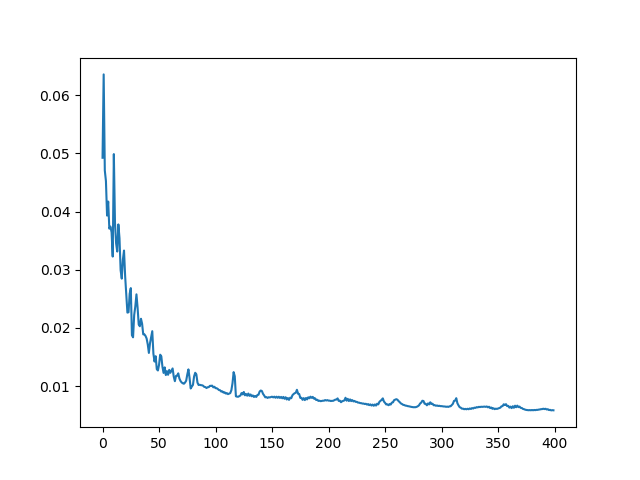

Training Accuracy: 96.16


In [23]:
# Load data
X, Y, labels, y = load_mnist()
tic = time.time()

dtype = torch.FloatTensor

# Convert numpy arrays to Pytorch Tensors
X = torch.from_numpy(X).type(dtype)
Y = torch.from_numpy(Y).type(dtype)

# size_layers = [784, 100, 10]

# Randomly initialize weights
w1 = torch.from_numpy(initalize_weights_relu(784, 100)).type(dtype)
w2 = torch.from_numpy(initalize_weights_relu(100, 10)).type(dtype)

for ix in range(epochs):
    n_examples = X.shape[0]
    # Forward pass: compute y_hat    
    a1 = X
    z2 = a1.mm(w1)
    a2 = z2.clamp(min=0)
    z3 = a2.mm(w2)
    a3 = z3.clamp(min=0)
    Y_hat = a3
    
    # Compute loss
    loss[ix] = (0.5) * np.square(Y_hat - Y).mean()
    # Backprop to compute gradients of w1 and w2 with respect to loss
    d3 = Y_hat - Y
    grad2 = a2.t().mm(d3) / n_examples
    d2_tmp = d3.mm(w2.t())
    d2 = d2_tmp.clone()
    d2[z2 <= 0] = 0 #d2 = d2 * derivate of ReLU function
    grad1 = a1.t().mm(d2) / n_examples
    
    # Update weights
    w1 = w1 - grad1
    w2 = w2 - grad2

print(str(time.time() - tic) + ' s')
    
# Ploting loss vs epochs
plt.figure()
ix = np.arange(epochs)
plt.plot(ix, loss)

# Training Accuracy
y_tmp = np.argmax(Y_hat.numpy(), axis=1)
y_hat = labels[y_tmp]

# Training Accuracy
acc = np.mean(1 * (y_hat == y))
print('Training Accuracy: ' + str(acc*100))

## 4. PyTorch CUDA tensors

1.1906187534332275 s


<IPython.core.display.Javascript object>


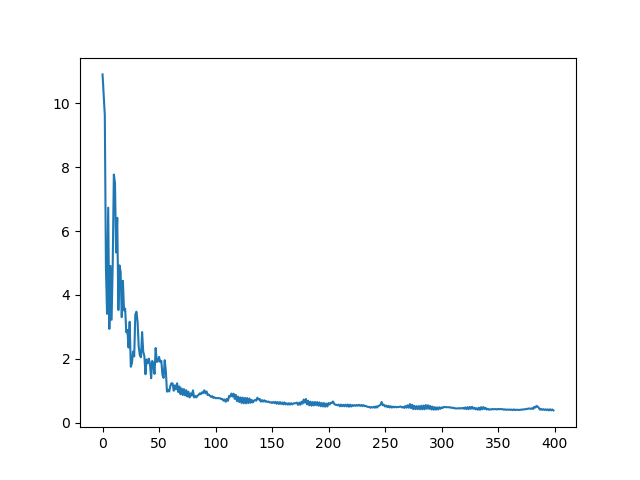

Training Accuracy: 95.30999999999999


In [24]:
# Load data
X, Y, labels, y = load_mnist()
tic = time.time()

dtype = torch.cuda.FloatTensor

# Convert numpy arrays to Pytorch Tensors
X = torch.from_numpy(X).type(dtype)
Y = torch.from_numpy(Y).type(dtype)

# size_layers = [784, 100, 10]

# Randomly initialize weights
w1 = torch.from_numpy(initalize_weights_relu(784, 100)).type(dtype)
w2 = torch.from_numpy(initalize_weights_relu(100, 10)).type(dtype)

for ix in range(epochs):
    n_examples = X.shape[0]
    # Forward pass: compute y_hat    
    a1 = X
    z2 = a1.mm(w1)
    a2 = z2.clamp(min=0)
    z3 = a2.mm(w2)
    a3 = z3.clamp(min=0)
    Y_hat = a3
        
    y_tmp = torch.max(Y_hat, dim=1)[1]
    y_tmp = y_tmp.cpu()
    y_hat = labels[y_tmp.numpy()]
    
    # Compute loss
    loss[ix] = (0.5) * np.square(y_hat - y).mean()
    # Backprop to compute gradients of w1 and w2 with respect to loss
    d3 = Y_hat - Y
    grad2 = a2.t().mm(d3) / n_examples
    d2_tmp = d3.mm(w2.t())
    d2 = d2_tmp.clone()
    d2[z2 <= 0] = 0 #d2 = d2 * derivate of ReLU function
    grad1 = a1.t().mm(d2) / n_examples
    
    # Update weights
    w1 = w1 - grad1
    w2 = w2 - grad2

print(str(time.time() - tic) + ' s')
    
# Ploting loss vs epochs
plt.figure()
ix = np.arange(epochs)
plt.plot(ix, loss)

# Training Accuracy
y_tmp = np.argmax(Y_hat.cpu().numpy(), axis=1)
y_hat = labels[y_tmp]

# Training Accuracy
acc = np.mean(1 * (y_hat == y))
print('Training Accuracy: ' + str(acc*100))

## PyTorch variables and automatic differentiation (autograd)

In [25]:
from torch.autograd import Variable

# Load data
X, Y, labels, y = load_mnist()
tic = time.time()

dtype = torch.FloatTensor

# Convert numpy arrays to Pytorch Tensors
# These tensors are wrapped in Variables to produce gradients, however we DO NOT need the gradients to this variables
X = Variable(torch.from_numpy(X).type(dtype), requires_grad = False)
Y = Variable(torch.from_numpy(Y).type(dtype), requires_grad = False)

# size_layers = [784, 100, 10]

# Randomly initialize weights
# These tensors are wrapped in Variables to produce gradients, however we NEED the gradients to this variables
w1 = Variable(torch.from_numpy(initalize_weights_relu(784, 100)).type(dtype), requires_grad = True)
w2 = Variable(torch.from_numpy(initalize_weights_relu(100, 10)).type(dtype), requires_grad = True)


for ix in range(epochs):
    n_examples = X.data.shape[0]
    # Forward pass: compute Y_hat by doing operations in variables    
    Y_hat = X.mm(w1).clamp(min=0).mm(w2).clamp(min=0)
    #       MatMul   ReLu         MatMul Relu
           
    # Compute loss
    loss_var = (0.5) * (Y_hat - Y).pow(2).mean()
    loss[ix] = loss_var.item()
    
    # Backward pass
    loss_var.backward()
    
    # Gradients
    grad1 = w1.grad.data
    grad2 = w2.grad.data
    
    # Update weights
    w1.data = w1.data - grad1 
    w2.data = w2.data - grad2
    
    # Reset gradients
    w1.grad.data.zero_()
    w2.grad.data.zero_()
    

print(str(time.time() - tic) + ' s')
    
# Ploting loss vs epochs
plt.figure()
ix = np.arange(epochs)
plt.plot(ix, loss)

# Training Accuracy
y_tmp = torch.max(Y_hat, dim=1)[1]
y_hat = labels[y_tmp.data.numpy()]
acc = np.mean(1 * (y_hat == y))
print('Training Accuracy: ' + str(acc*100))

IndexError: invalid index of a 0-dim tensor. Use tensor.item() to convert a 0-dim tensor to a Python number

## PyTorch `nn` package

In [ ]:
from torch.autograd import Variable

# Load data
X, Y, labels, y = load_mnist()
tic = time.time()

dtype = torch.FloatTensor

# Convert numpy arrays to Pytorch Tensors
# These tensors are wrapped in Variables to produce gradients, however we DO NOT need the gradients to this variables
X = Variable(torch.from_numpy(X).type(dtype), requires_grad = False)
Y = Variable(torch.from_numpy(Y).type(dtype), requires_grad = False)

model = torch.nn.Sequential(
            torch.nn.Linear(784, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 10),
            torch.nn.ReLU(),
        )

loss_fn = torch.nn.MSELoss()

for ix in range(epochs):
    # Forward pass: compute Y_hat by doing operations in variables    
    Y_hat = model(X)
    
    # Compute loss
    loss_var = 0.5 * loss_fn(Y_hat, Y)
    loss[ix] = loss_var.data[0]
    
    # Reset gradients
    model.zero_grad()
    
    # Backward pass
    loss_var.backward()
    
    # Update weights
    for param in model.parameters():
        param.data = param.data - param.grad.data
    
print(str(time.time() - tic) + ' s')
    
# Ploting loss vs epochs
plt.figure()
ix = np.arange(epochs)
plt.plot(ix, loss)

# Training Accuracy
Y_hat = model(X)
y_tmp = torch.max(Y_hat, dim=1)[1]
y_hat = labels[y_tmp.data.numpy()]
acc = np.mean(1 * (y_hat == y))
print('Training Accuracy: ' + str(acc*100))

## PyTorch `nn` package (in GPU)

In [17]:
from torch.autograd import Variable

# Load data
X, Y, labels, y = load_mnist()
tic = time.time()

dtype = torch.cuda.FloatTensor

# Convert numpy arrays to Pytorch Tensors
# These tensors are wrapped in Variables to produce gradients, however we DO NOT need the gradients to this variables
X = Variable(torch.from_numpy(X).type(dtype), requires_grad = False)
Y = Variable(torch.from_numpy(Y).type(dtype), requires_grad = False)

model = torch.nn.Sequential(
            torch.nn.Linear(784, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 10),
            torch.nn.ReLU(),
        )

model.cuda(0)

loss_fn = torch.nn.MSELoss()

for ix in range(epochs):
    # Forward pass: compute Y_hat by doing operations in variables    
    Y_hat = model(X)
    
    # Compute loss
    loss_var = 0.5 * loss_fn(Y_hat, Y)
    loss[ix] = loss_var.data[0]
    
    # Reset gradients
    model.zero_grad()
    
    # Backward pass
    loss_var.backward()
    
    # Update weights
    for param in model.parameters():
        param.data = param.data - param.grad.data
    
print(str(time.time() - tic) + ' s')
    
# Ploting loss vs epochs
plt.figure()
ix = np.arange(epochs)
plt.plot(ix, loss)

# Training Accuracy
Y_hat = model(X)
y_tmp = torch.max(Y_hat, dim=1)[1]
y_hat = labels[y_tmp.data.cpu().numpy()]
acc = np.mean(1 * (y_hat == y))
print('Training Accuracy: ' + str(acc*100))

IndexError: invalid index of a 0-dim tensor. Use tensor.item() to convert a 0-dim tensor to a Python number